<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/DL4cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Using Deep Learning Algorithms to Improve Cybersecurity."



# Introduction

The **CICIDS2017 dataset** is a comprehensive collection of labeled network traffic data curated by the Canadian Institute for Cybersecurity (CIC). It is widely used for evaluating the performance of intrusion detection systems (IDS) and benchmarking cybersecurity models.

This dataset was created to reflect real-world scenarios by simulating benign and malicious traffic using realistic network environments, including both modern and legacy protocols. The data was generated using B-Profile systems, which emulate the behavior of human users based on statistical distributions. It captures traffic from a variety of attack types, making it suitable for training and testing both signature-based and anomaly-based IDS models.

Key characteristics of the CICIDS2017 dataset include:

- **Time-stamped flow-based data** collected using CICFlowMeter.
- **Multiple attack scenarios** such as DDoS, brute-force, botnet, infiltration, port scanning, web attacks, and more.
- **Seven-day capture** (Monday to Sunday) with each day focusing on different attack types and benign traffic profiles.
- **Features**: Over 80 network traffic features including flow duration, packet size, header flags, and inter-arrival times.
- **Labeling**: Each traffic flow is labeled as either benign or one of the specific attack types.

The CICIDS2017 dataset is particularly valuable for researchers and developers working on:

- Supervised learning-based IDS
- Unsupervised anomaly detection
- Real-time traffic classification
- Security policy and defense system testing

By offering a well-structured and diverse dataset, CICIDS2017 helps bridge the gap between academic research and practical cybersecurity applications.



 Reasons CICIDS2017 is Good for Cybersecurity:
1. Realistic Traffic
Simulates real-world network traffic, both benign and malicious.

Includes user behavior profiles that mimic human interactions with networks.

2. Diverse Attack Types
Covers multiple attack categories, including:

- DDoS

- Brute-force attacks

- Port scanning

- Botnet activity

- Infiltration

- Web attacks (e.g., SQL injection, XSS)

3. Labeled and Time-stamped
- All network flows are clearly labeled, allowing for supervised ML training.

- Time-series structure enables research in real-time detection and temporal analysis.

4. Rich Feature Set
Extracted using CICFlowMeter, includes 80+ flow features like:

- Flow duration

- Packet sizes

- Header flags

- Flow direction

- Suitable for deep analysis and feature engineering.

5. Well-documented and Open-Source
- Publicly available for academic and commercial research.

- Comes with detailed documentation and tools.

# Step 1: Set Up the Environment



In [1]:
# Install required libraries
!pip install transformers torch pandas numpy scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [31]:
# Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import pearsonr, levene, kruskal
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from google.colab import drive
import gc


In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


- Install transformers for SecBERT/BERT, torch for model training, pandas for data handling, scikit-learn for metrics, and imbalanced-learn for SMOTE.

- Mount Google Drive to load the CICIDS2017 dataset (assumed to be in /content/drive/MyDrive/CICIDS2017/).

- Set the device to GPU for faster training.



# Step 2: Load and Combine the CICIDS2017 Dataset



In [15]:
# Path to the zip file
zip_path = '/content/drive/MyDrive/network-intrusion-dataset.zip'
extract_dir = '/content/cicids2017/'

In [16]:
# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [17]:
# List of CSV files
csv_files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv'
]

In [22]:
# Load and combine CSVs
dfs = []
for file in csv_files:
    file_path = os.path.join(extract_dir, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)

# Display basic information
print("Combined Dataset Shape:", df.shape)
print("Columns:", df.columns)
print("Label Distribution:\n", df[' Label'].value_counts())

# Handle missing values
df = df.replace([np.inf, -np.inf], np.nan)  # Replace infinities
df = df.dropna()


Combined Dataset Shape: (2830743, 79)
Columns: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' P

In [23]:
# Simplify labels (binary classification: Benign vs. Malicious)
df[' Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print("Binary Label Distribution:\n", df[' Label'].value_counts())

Binary Label Distribution:
  Label
0    2271320
1     556556
Name: count, dtype: int64


In [32]:
# Free memory
del dfs
gc.collect()

NameError: name 'dfs' is not defined

- Unzip network-intrusion-dataset.zip to /content/cicids2017/.

- Load each CSV file into a DataFrame and combine them using pd.concat.

- Check dataset shape, columns, and label distribution.

- Replace infinities with NaN and drop rows with missing values.

- Convert labels to binary (0 for BENIGN, 1 for malicious). For multi-class, modify this step later.

- Note: If the label column is named Attack Type instead of Label, update all references (e.g., df['Attack Type']).



# Step 3: Preprocessing Pipeline



In [27]:
# Preprocessing functions
def get_numerical_categorical_features(df, target_col=' Label'):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [col for col in numerical_features if col != target_col]
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_features = [col for col in categorical_features if col != target_col]
    return numerical_features, categorical_features

def correlation_analysis(df, numeric_features, threshold=0.8):
    corr_matrix = df[numeric_features].corr(method='pearson')
    high_corr = []
    for i in range(len(numeric_features)):
        for j in range(i + 1, len(numeric_features)):
            corr, _ = pearsonr(df[numeric_features[i]], df[numeric_features[j]])
            if abs(corr) > threshold:
                high_corr.append((numeric_features[i], numeric_features[j], corr))
    return high_corr, corr_matrix

def variance_analysis(df, numeric_features, target_col=' Label'):
    levene_results = {}
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature] for label in df[target_col].unique()]
        stat, p = levene(*groups, center='median')
        levene_results[feature] = {'statistic': stat, 'p_value': p}
    return levene_results


Numerical Features: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag

<ipython-input-27-f5490bf55e18>:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df[numeric_features[i]], df[numeric_features[j]])


Highly Correlated Features: [(' Flow Duration', 'Fwd IAT Total', np.float64(0.998559688264724)), (' Flow Duration', 'Bwd IAT Total', np.float64(0.8225167161366596)), (' Total Fwd Packets', ' Total Backward Packets', np.float64(0.9990699519181786)), (' Total Fwd Packets', ' Total Length of Bwd Packets', np.float64(0.9969928057062772)), (' Total Fwd Packets', 'Subflow Fwd Packets', np.float64(1.0)), (' Total Fwd Packets', ' Subflow Bwd Packets', np.float64(0.9990699519181786)), (' Total Fwd Packets', ' Subflow Bwd Bytes', np.float64(0.9969866623498994)), (' Total Fwd Packets', ' act_data_pkt_fwd', np.float64(0.8873865746135663)), (' Total Backward Packets', ' Total Length of Bwd Packets', np.float64(0.9944292897324183)), (' Total Backward Packets', 'Subflow Fwd Packets', np.float64(0.9990699519181786)), (' Total Backward Packets', ' Subflow Bwd Packets', np.float64(0.9999999999999997)), (' Total Backward Packets', ' Subflow Bwd Bytes', np.float64(0.9944241119040484)), (' Total Backward P

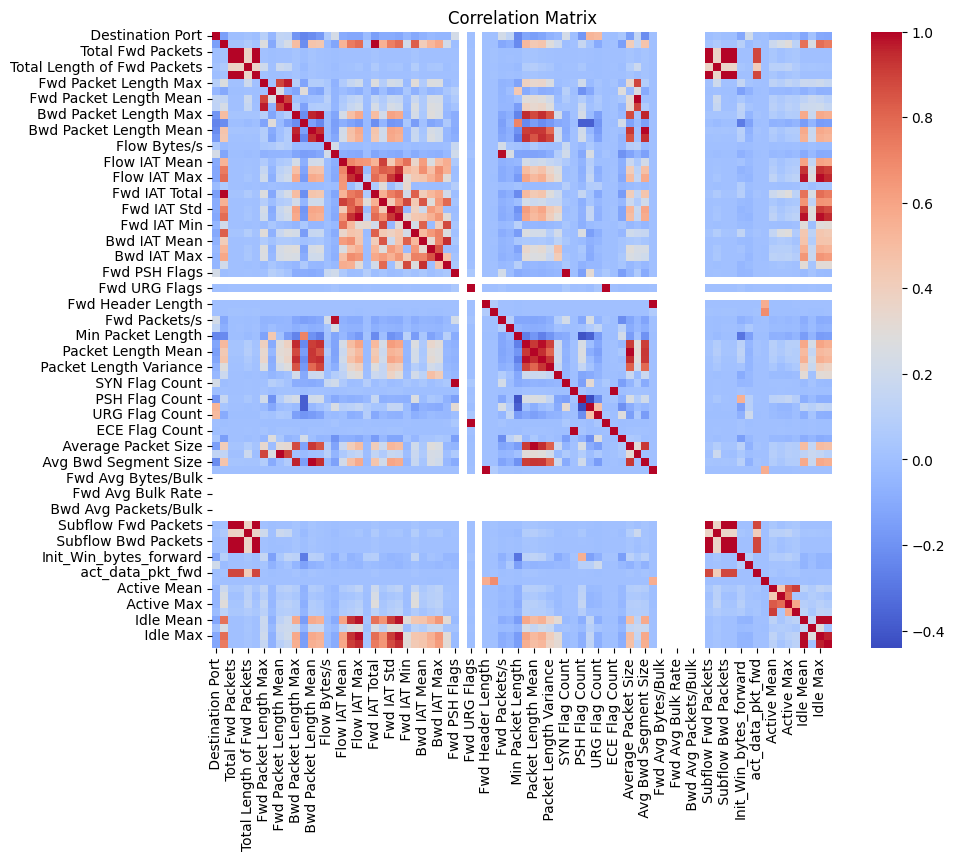

/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


Levene's Test Results: {' Destination Port': {'statistic': np.float64(64225.70544024853), 'p_value': np.float64(0.0)}, ' Flow Duration': {'statistic': np.float64(136486.56760672224), 'p_value': np.float64(0.0)}, ' Total Fwd Packets': {'statistic': np.float64(34.70320619459995), 'p_value': np.float64(3.840418524050961e-09)}, ' Total Backward Packets': {'statistic': np.float64(32.818843028824276), 'p_value': np.float64(1.0116971231814216e-08)}, 'Total Length of Fwd Packets': {'statistic': np.float64(772.3652430426125), 'p_value': np.float64(5.800236350946678e-170)}, ' Total Length of Bwd Packets': {'statistic': np.float64(16.15308699573345), 'p_value': np.float64(5.842478440321314e-05)}, ' Fwd Packet Length Max': {'statistic': np.float64(8893.968013527186), 'p_value': np.float64(0.0)}, ' Fwd Packet Length Min': {'statistic': np.float64(50558.01115836572), 'p_value': np.float64(0.0)}, ' Fwd Packet Length Mean': {'statistic': np.float64(11276.810164320044), 'p_value': np.float64(0.0)}, ' F

KeyboardInterrupt: 

In [28]:
def feature_importance_kruskal(df, numeric_features, target_col=' Label'):
    kruskal_results = []
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature] for label in df[target_col].unique()]
        # Check if all groups have identical values
        if not all(group.nunique() == 1 for group in groups): # Check if all groups have only 1 unique value
            stat, p = kruskal(*groups) # Only run kruskal test if values are not identical
            kruskal_results.append({'Feature': feature, 'H_statistic': stat, 'p_value': p})
        else:
            print(f"Feature '{feature}' has identical values across groups, skipping Kruskal-Wallis test.")
            kruskal_results.append({'Feature': feature, 'H_statistic': np.nan, 'p_value': np.nan}) # Add with NaN for features not tested

    return pd.DataFrame(kruskal_results)

def feature_importance_tree(df, numeric_features, target_col=' Label'):
    X = df[numeric_features]
    y = df[target_col]
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importance = pd.DataFrame({
        'Feature': numeric_features,
        'Importance': clf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Cross-validation scores
    cv_scores = cross_val_score(clf, X, y, cv=5, scoring='f1_weighted')

    # Confusion matrix
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    labels = sorted(df[target_col].unique())

    return feature_importance, cm, labels, cv_scores

def outlier_percentage(df, numeric_features):
    outlier_results = {}
    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        outlier_results[feature] = (len(outliers) / len(df)) * 100
    return outlier_results

# Apply preprocessing steps
# 1. Get numerical and categorical features
numerical_features, categorical_features = get_numerical_categorical_features(df)
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

# 2. Correlation analysis
high_corr, corr_matrix = correlation_analysis(df, numerical_features)
print("Highly Correlated Features:", high_corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Variance analysis
levene_results = variance_analysis(df, numerical_features)
print("Levene's Test Results:", levene_results)

# 4. Feature importance (Kruskal-Wallis)
kruskal_df = feature_importance_kruskal(df, numerical_features)
print("Kruskal-Wallis Results:\n", kruskal_df)

# 5. Feature importance (Tree Model)
feature_importance, cm, labels, cv_scores = feature_importance_tree(df, numerical_features)
print("Feature Importance (Tree Model):\n", feature_importance)
print("Cross-Validation F1 Scores:", cv_scores)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# 6. Outlier percentage
outlier_results = outlier_percentage(df, numerical_features)
print("Outlier Percentage:", outlier_results)

- Step 1: Identify numerical (e.g., Flow Duration) and categorical (e.g., Source IP) features, excluding the target column.

- Step 2: Compute Pearson correlations and identify pairs with correlation > 0.8. Visualize the correlation matrix.

- Step 3: Use Levene’s test to check variance homogeneity across attack types for each numerical feature.

- Step 4: Apply the Kruskal-Wallis test to rank numerical features by their ability to distinguish attack types.

- Step 5: Train a Random Forest classifier to rank feature importance, compute cross-validation F1 scores, and plot a confusion matrix.

- Step 6: Calculate the percentage of outliers for each numerical feature using the IQR method.

Note: If the target column is Attack Type, update target_col='Attack Type' in all functions.

